In [1]:
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Total number of images we want to have in each class
NUM_AUG_IMAGES_WANTED = 1000 

# We will resize the images
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

### What files are available?

In [3]:
os.listdir('/Users/amankkashyap/Downloads/archive')

['Montgomery', '.DS_Store', 'ChinaSet_AllFiles']

### What are the labels?


The label is part of the file name.

Example: *CHNCXR_0470__**1**.png*<br>

**0** = Normal (No TB)<br>
**1** = TB<br>

Each of the two datasets has a text file containing meta-data.

In [4]:
print(len(os.listdir('/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')))
print(len(os.listdir('/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png')))

2763
2239


### Create a Dataframe containing all images

In [5]:
shen_image_list = os.listdir('/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png')

In [6]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(2762, 1)
(2238, 1)


In [7]:
df_shen.head()

,image_id
0,CHNCXR_0492_1.png
1,Normal-1003_0.png
2,Normal-968_0.png
3,Normal-1046_0.png
4,Normal-1497_0.png


In [8]:
df_mont.head()

,image_id
0,Normal-2375_0.png
1,Normal-2330_0.png
2,Normal-1840_0.png
3,Normal-3375_0.png
4,Normal-3330_0.png


### Assign labels to the images

In [9]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [10]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)


### Check the class distribution

In [11]:
# Shenzen Dataset

df_shen['target'].value_counts()

Normal          2076
Tuberculosis     686
Name: target, dtype: int64

In [12]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          1830
Tuberculosis     408
Name: target, dtype: int64

Display a random sample of images from each dataset by target

In [13]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Given a column in a dataframe,
    this function takes a sample of each class and displays that
    sample in one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

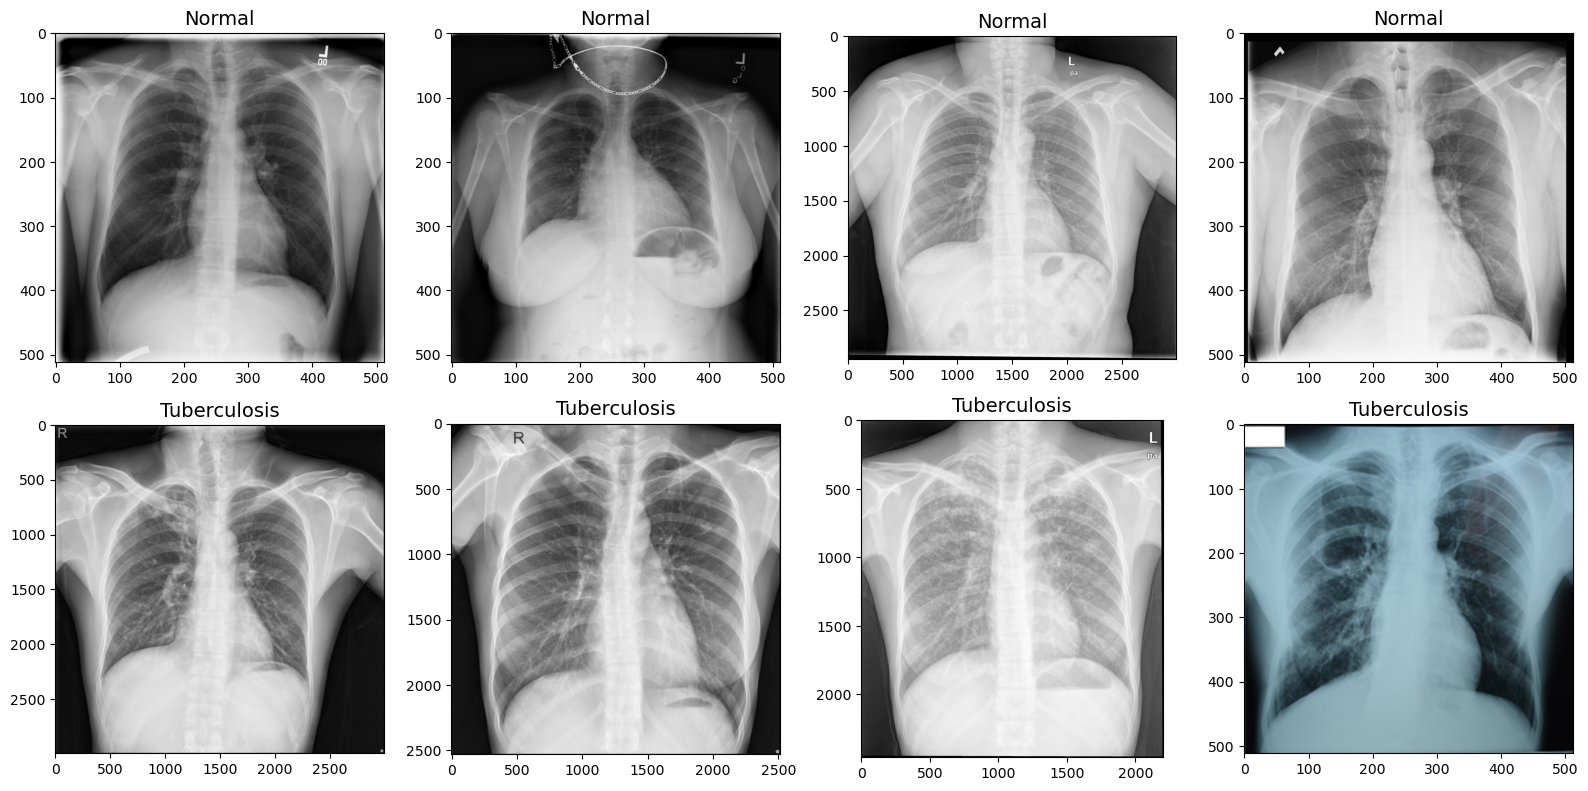

In [14]:
# Shenzen Dataset
import imageio.v2 as imageio

IMAGE_PATH = '/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

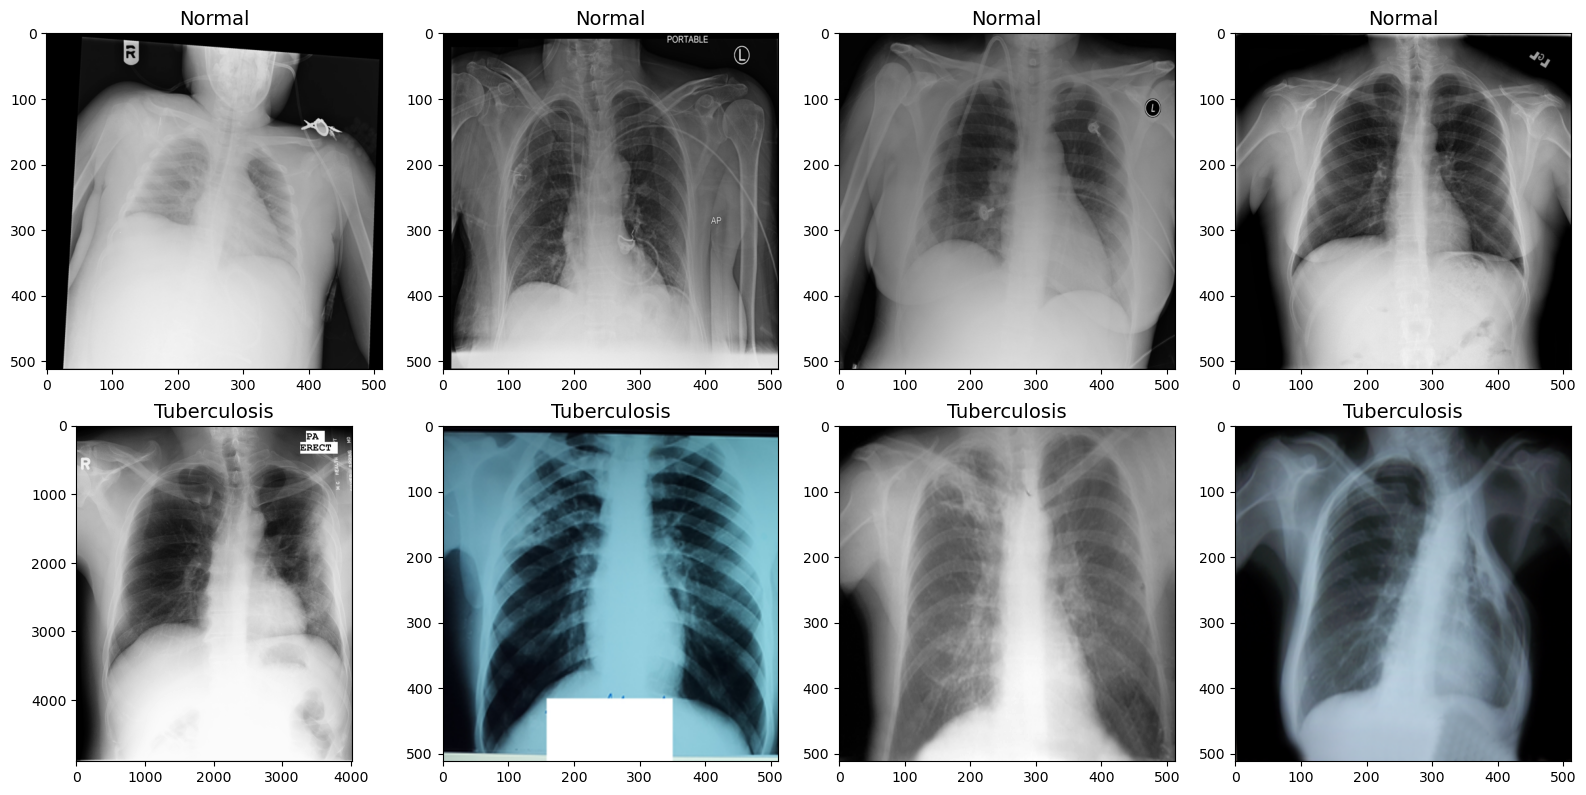

In [15]:
# Montgomery Dataset

IMAGE_PATH = '/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

### What is the shape of each image and what are its max and min pixel values?
Let's include all this info in the dataframes we created above.

In [16]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values of the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # The shape of the image is obtained using image.shape. 
    # If the image is grayscale, the shape will be (height, width), and if it's color, the shape will be (height, width, num_channels).
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    
    
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output



In [17]:
IMAGE_PATH = '/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

# Use the read_image_sizes function to get image information for each image_id
m = np.stack(df_shen['image_id'].apply(read_image_sizes))

# Create a new dataframe with the extracted image information
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])

# Concatenate the new dataframe with the original df_shen dataframe along columns
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0492_1.png,Tuberculosis,2651,2430,3,255,0
1,Normal-1003_0.png,Normal,512,512,3,255,0
2,Normal-968_0.png,Normal,512,512,3,255,4
3,Normal-1046_0.png,Normal,512,512,3,248,0
4,Normal-1497_0.png,Normal,512,512,3,252,0


In [18]:
IMAGE_PATH = '/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,Normal-2375_0.png,Normal,512,512,3,248,0
1,Normal-2330_0.png,Normal,512,512,3,255,0
2,Normal-1840_0.png,Normal,512,512,3,254,0
3,Normal-3375_0.png,Normal,512,512,3,255,0
4,Normal-3330_0.png,Normal,512,512,3,251,3


### How many channels do the images in each dataset have?

In [19]:
df_shen['c'].value_counts()

3    2762
Name: c, dtype: int64

In [20]:
df_mont['c'].value_counts()

3    2238
Name: c, dtype: int64

We see that all images have 3 channels.

### Create the Train and Val Sets

In [21]:
df_mont['target'].value_counts()

Normal          1830
Tuberculosis     408
Name: target, dtype: int64

In [22]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(5000, 7)

In [23]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [24]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
1003,CHNCXR_0127_0.png,Normal,2382,2478,3,255,0,0
475,Normal-525_0.png,Normal,512,512,3,255,0,0
738,Normal-310_0.png,Normal,512,512,3,249,0,0
1081,Normal-1433_0.png,Normal,512,512,3,252,0,0
3955,Normal-2959_0.png,Normal,512,512,3,255,0,0


In [25]:
# train_test_split
# we shall use 15% of the df for validation and the rest for training.
y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(4250, 8)
(750, 8)


In [26]:
df_train['target'].value_counts()

Normal          3320
Tuberculosis     930
Name: target, dtype: int64

In [27]:
df_val['target'].value_counts()

Normal          586
Tuberculosis    164
Name: target, dtype: int64

### Create a Directory Structure

In [32]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


### Transfer the images into the folders

In [33]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [34]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/Users/amankkashyap/Downloads/archive/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/Users/amankkashyap/Downloads/archive/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [35]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))


3320
930


In [36]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))


586
164


Copy the train images into aug_dir

aug_dir is where we temporarily store images from a given class before feeding them into the generator for augmentation.¶

We will not be augmenting on the fly. We will create augmented images, store them in folders together with the raw images and then feed these into the generators. We found that working this way makes the training process run faster.

In [37]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'Normal'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    
    num_files = len(os.listdir(img_dir))
    
    # this creates a similar amount of images for each class
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 3320 images belonging to 1 classes.
Found 930 images belonging to 1 classes.


In [38]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

3320
1030


In [39]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

586
164


### Visualize a batch of augmented images

In [40]:
# plots images with labels within jupyter notebook

def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        


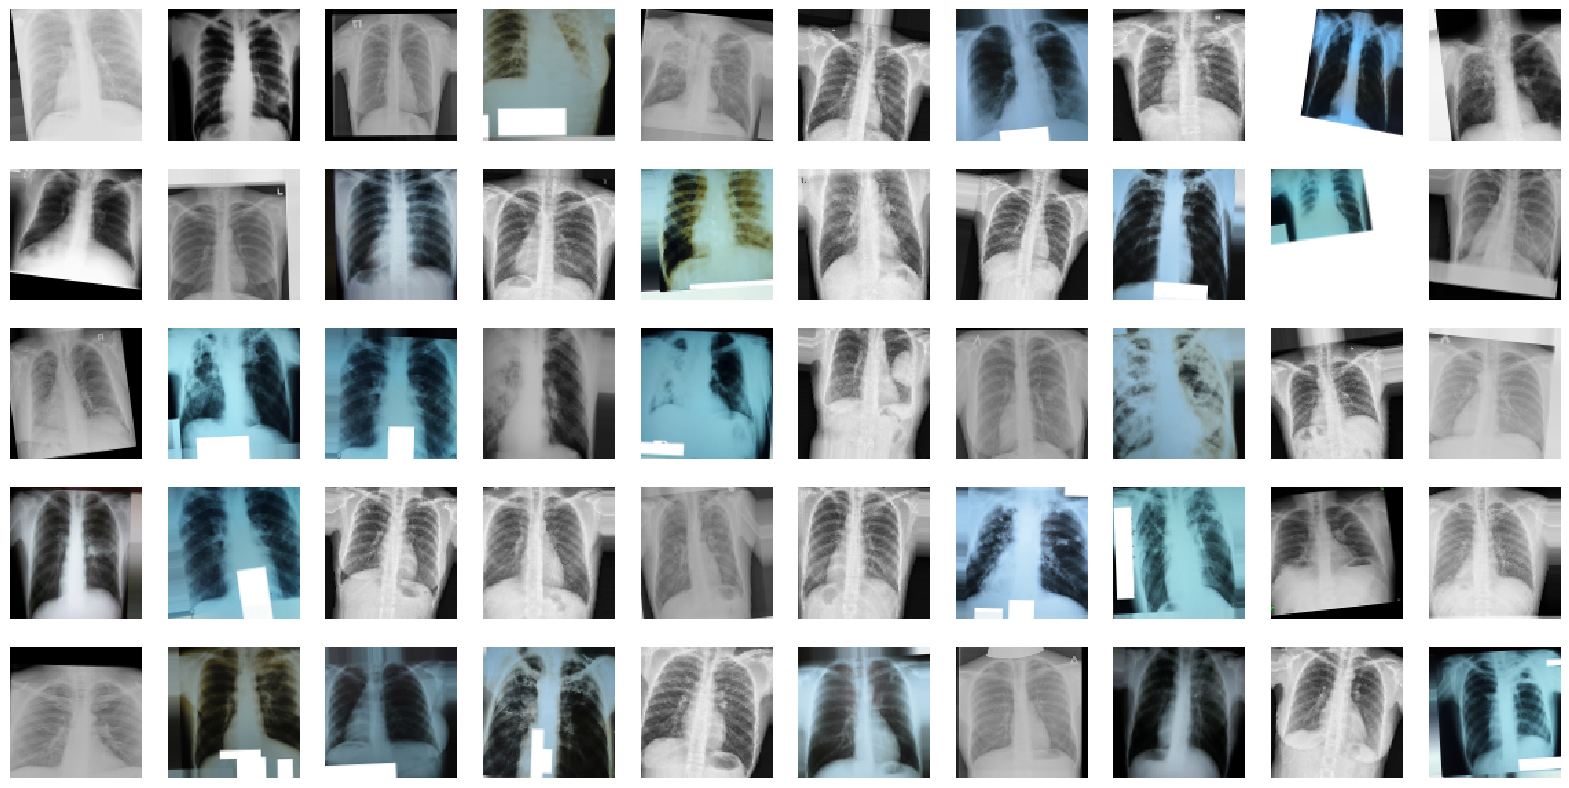

In [41]:
plots(imgs, titles=None) # titles=labels will display the image labels

In [42]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building


### Set Up the Generators

In [43]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [44]:

datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 4350 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


### Create the Model Architecture

In [45]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

### Train the Model

In [46]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [48]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=10, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/10
425/425 [==============================] - ETA: 0s - loss: 0.3639 - accuracy: 0.8515
Epoch 1: val_accuracy improved from -inf to 0.88667, saving model to model.h5
425/425 [==============================] - 49s 116ms/step - loss: 0.3639 - accuracy: 0.8515 - val_loss: 0.3065 - val_accuracy: 0.8867 - lr: 1.0000e-04
Epoch 2/10
425/425 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8656
Epoch 2: val_accuracy improved from 0.88667 to 0.89067, saving model to model.h5
425/425 [==============================] - 50s 117ms/step - loss: 0.3133 - accuracy: 0.8656 - val_loss: 0.2631 - val_accuracy: 0.8907 - lr: 1.0000e-04
Epoch 3/10
425/425 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8718
Epoch 3: val_accuracy improved from 0.89067 to 0.89467, saving model to model.h5
425/425 [==============================] - 50s 117ms/step - loss: 0.3016 - accuracy: 0.8718 - val_loss: 0.2560 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 4/10
425/425 

### Evaluate the model using the val set

In [49]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [50]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

75/75 [==============================] - 2s 30ms/step - loss: 0.2174 - accuracy: 0.9253
val_loss: 0.21742233633995056
val_acc: 0.9253333210945129


### Plot the Training Curves

<Figure size 640x480 with 0 Axes>

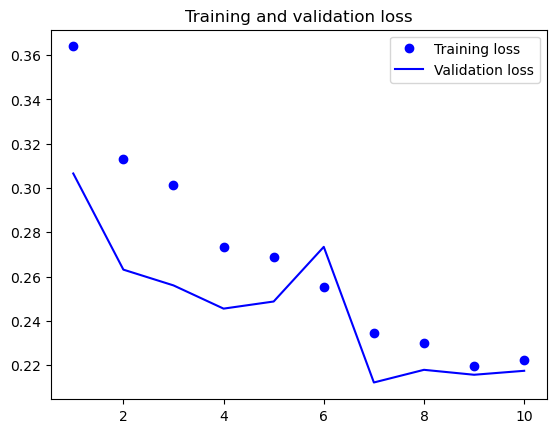

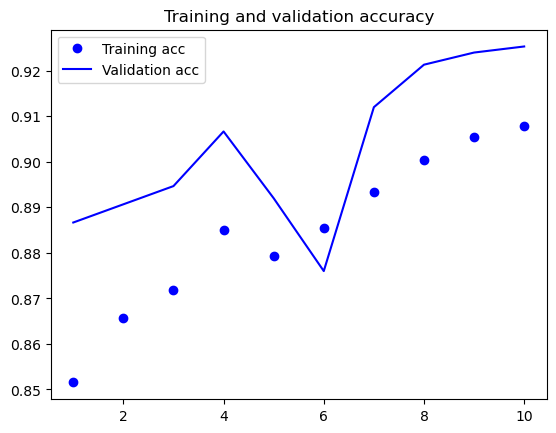

<Figure size 640x480 with 0 Axes>

In [51]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Create a Confusion Matrix

In [52]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [53]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
# Print the label associated with each class
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [55]:
# make a prediction
predictions = model.predict(test_gen, steps=val_steps, verbose=1)

75/75 [==============================] - 2s 30ms/step


In [56]:
predictions.shape

(750, 2)

In [57]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [58]:
test_labels.shape

(750,)

In [59]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [60]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[558  28]
 [ 28 136]]


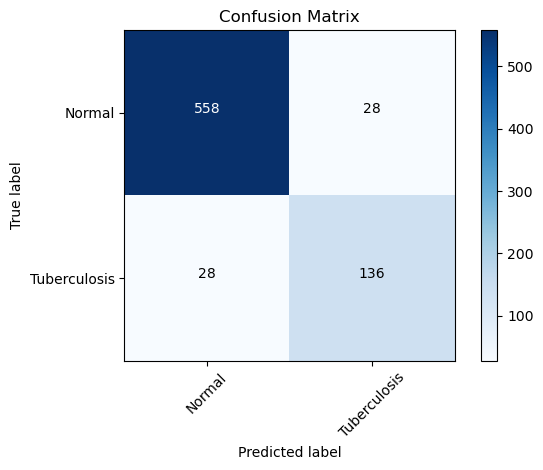

In [61]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [62]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [63]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)


              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       586
Tuberculosis       0.83      0.83      0.83       164

    accuracy                           0.93       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.93      0.93      0.93       750



**Recall **= Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.

The F1 score is greater than 0.8. From the confusion matrix we see that our model has a  tendency to classify TB images as Normal, more so than to classify Normal images as TB. 